Import needed libraries and the dataset csv

In [42]:
import pandas as pd
import numpy as np
from pathlib import Path

# Build path to file
# Selects current working directory
cwd = Path.cwd()
csv_path = 'data/dataframe.csv'
csv_cleaned_path = 'data/dataframe_cleaned.csv'
src_path = (cwd / csv_path).resolve()
out_path = (cwd / csv_cleaned_path).resolve()

# Read the csv
csv = pd.read_csv(src_path, index_col=0)
csv.shape

(19980, 20)

Clean up the dataset

In [76]:
# Removing unneeded data
# dropping empty rows
csv = csv.dropna(how='all')
# dropping duplicates (if any)
csv = csv.drop_duplicates()
# Dropping house and appartment groups since they have no data
csv = csv.drop(csv[(csv['property_type'] == 'HOUSE_GROUP') | (csv['property_type'] == 'APARTMENT_GROUP')].index)
# Drop rows without a price property
csv = csv.drop(csv[pd.isna(csv['price']) == True].index)
# Drop rows with 0 rooms
csv = csv.drop(csv[csv['number_rooms'] == 0].index)
# Drop rows without a living area property
csv = csv.drop(csv[pd.isna(csv['living_area']) == True].index)
# Assuming that a NaN value or 0 means no kitchen installed, replacing the strings with integers
# 0 = NOT_INSTALLED, 0.5 = SEMI_EQUIPPED, 1 = INSTALLED, 2 = HYPER_EQUIPPED
csv['kitchen'] = csv['kitchen'].fillna(0)
csv['kitchen'] = csv['kitchen'].replace('0', 0)
csv['kitchen'] = csv['kitchen'].replace('NOT_INSTALLED', 0)
csv['kitchen'] = csv['kitchen'].replace('USA_UNINSTALLED', 0)
csv['kitchen'] = csv['kitchen'].replace('SEMI_EQUIPPED', 0.5)
csv['kitchen'] = csv['kitchen'].replace('USA_SEMI_EQUIPPED', 0.5)
csv['kitchen'] = csv['kitchen'].replace('INSTALLED', 1)
csv['kitchen'] = csv['kitchen'].replace('USA_INSTALLED', 1)
csv['kitchen'] = csv['kitchen'].replace('HYPER_EQUIPPED', 2)
csv['kitchen'] = csv['kitchen'].replace('USA_HYPER_EQUIPPED', 2)
# Filling empty values and changing true/false to 1/0
csv['furnished'] = csv['furnished'].fillna(0)
csv['furnished'] = csv['furnished'].replace(False, 0)
csv['furnished'] = csv['furnished'].replace(True, 1)
# Assuming that a NaN value,0 or -1 means no fireplace installed
csv['fireplace'] = csv['fireplace'].fillna(0)
csv['fireplace'] = csv['fireplace'].replace(-1, 0)
# Filling empty values and changing true/false to 1/0
csv['terrace'] = csv['terrace'].fillna(0)
csv['terrace'] = csv['terrace'].replace(False, 0)
csv['terrace'] = csv['terrace'].replace(True, 1)
# Assuming the surface area = living area in case of apartments
to_replace = csv[((csv['surface_land'] == 'UNKNOWN')|(pd.isna(csv['surface_land']) == True)) & (csv['property_type'] == 'APARTMENT')]
to_replace = to_replace.reset_index()
# Looping through rows to replace the values
for index, row in to_replace.iterrows():
    csv.loc[row['index'], 'surface_land'] = row['living_area']
# Dropping rows with no surface area 
csv = csv.drop(csv[(csv['surface_land'] == 'UNKNOWN') | (pd.isna(csv['surface_land']) == True) | (csv['surface_land'] == 0)].index)
# Dropping rows with no facade info
csv = csv.drop(csv[(csv['number_facades'] == 'UNKNOWN') | (pd.isna(csv['number_facades']) == True)].index)
# Filling empty values and changing true/false to 1/0
csv['swimming_pool'] = csv['swimming_pool'].fillna(0)
csv['swimming_pool'] = csv['swimming_pool'].replace(False, 0)
csv['swimming_pool'] = csv['swimming_pool'].replace(True, 1)
csv = csv.drop(csv[(csv['building_state'] == 'UNKNOWN') | (pd.isna(csv['building_state']) == True)].index)


This codeblock will drop all rows if:

 - terrace = 1 but no terrace_area is present
 - garden = 1 but no garden_area is present

This drops a lot of rows but results in a cleaner dataset. 

You can opt to use the codeblock below instead to keep a bigger dataset.

In [44]:
# If terrace = 1 but no terrace_area present, drop the row
csv = csv.drop(csv[(csv['terrace'] == 1) & (pd.isna(csv['terrace_area']) == True)].index)
# Filling empty values and changing true/false to 1/0
csv['terrace_area'] = csv['terrace_area'].fillna(0)
# If garden = 1 but no garden_area present, drop the row
csv = csv.drop(csv[(csv['garden'] == 1) & (pd.isna(csv['garden_area']) == True)].index)
# No garden, filling empty values
csv['garden'] = csv['garden'].fillna(0)
csv['garden'] = csv['garden'].replace(False, 0)
csv['garden'] = csv['garden'].replace(True, 1)
csv['garden_area'] = csv['garden_area'].fillna(0)

This codeblock fills in missing values of garden_area and terrace_area with the mean value of identical property types

In [45]:

"""filter = csv[(csv['terrace'] == 1) & (pd.isna(csv['terrace_area']) == False)][['property_type', 'terrace_area']]
mean_calc = (filter.groupby('property_type')['terrace_area'].sum())/(filter.groupby('property_type')['terrace_area'].count())
# Loop through property types
for type in csv['property_type'].unique():
    try:
        csv['terrace_area'] = csv[(csv['terrace'] == 1) & (pd.isna(csv['terrace_area']) == True) & (csv['property_type'] == type)]['terrace_area'].replace(np.nan, mean_calc.loc[type])
    except: 
        pass
# No terrace, terrace_area = 0
csv['terrace_area'] = csv['terrace_area'].fillna(0)
# Filling empty values and changing true/false to 1/0
csv['garden'] = csv['garden'].fillna(0)
csv['garden'] = csv['garden'].replace(False, 0)
csv['garden'] = csv['garden'].replace(True, 1)
# If garden = 1 but no garden_area present, calculate the mean garden_area of property_type
filter = csv[(csv['garden'] == 1) & (pd.isna(csv['garden_area']) == False)][['property_type', 'garden_area']]
mean_calc = (filter.groupby('property_type')['garden_area'].sum())/(filter.groupby('property_type')['garden_area'].count())
# Loop through property types
for type in csv['property_type'].unique():
    try:
        csv['garden_area'] = csv[(csv['garden'] == 1) & (pd.isna(csv['garden_area']) == True) & (csv['property_type'] == type)]['garden_area'].replace(np.nan, mean_calc.loc[type])
    except: 
        pass
# No terrace, terrace_area = 0
csv['garden_area'] = csv['garden_area'].fillna(0)"""

"filter = csv[(csv['terrace'] == 1) & (pd.isna(csv['terrace_area']) == False)][['property_type', 'terrace_area']]\nmean_calc = (filter.groupby('property_type')['terrace_area'].sum())/(filter.groupby('property_type')['terrace_area'].count())\n# Loop through property types\nfor type in csv['property_type'].unique():\n    try:\n        csv['terrace_area'] = csv[(csv['terrace'] == 1) & (pd.isna(csv['terrace_area']) == True) & (csv['property_type'] == type)]['terrace_area'].replace(np.nan, mean_calc.loc[type])\n    except: \n        pass\n# No terrace, terrace_area = 0\ncsv['terrace_area'] = csv['terrace_area'].fillna(0)\n# Filling empty values and changing true/false to 1/0\ncsv['garden'] = csv['garden'].fillna(0)\ncsv['garden'] = csv['garden'].replace(False, 0)\ncsv['garden'] = csv['garden'].replace(True, 1)\n# If garden = 1 but no garden_area present, calculate the mean garden_area of property_type\nfilter = csv[(csv['garden'] == 1) & (pd.isna(csv['garden_area']) == False)][['property_ty

In [46]:
# Change strings to floats in certain columns
csv['surface_land']=csv['surface_land'].astype("float")
csv['number_facades']=csv['number_facades'].astype("float")

Save the cleaned up csv 

In [47]:
# Saves cleaned up csv to 'data/dataframe_cleaned.csv'
csv.to_csv(out_path)

Looks up the coordinates of the locality and does a reverse lookup to get the full adress information. 

(Not used, adapted scraper instead)

In [143]:
# Import the required library
from geopy.geocoders import Nominatim
class address ():

    def __init__(self, locality) -> None:

        # Initialize Nominatim API
        geolocator = Nominatim(user_agent="MyApp")
        geocode = lambda query: geolocator.geocode("%s, BE" % query)
        location = geocode(locality)

        # Latitude & Longitude input
        Latitude = str(location.latitude)
        Longitude = str(location.longitude)
    
        location = geolocator.reverse(Latitude + "," + Longitude)

        self.address = location.raw['address']
        self.city = self.address.get('city', '')
        self.state = self.address.get('state', '')
        self.zipcode = self.address.get('postcode')

test = address('Waterloo')

test.address

{'amenity': 'Maison communale de Waterloo',
 'house_number': '28',
 'road': 'Rue François Libert',
 'quarter': 'Petit Paris',
 'hamlet': 'Le Pachy',
 'town': 'Waterloo',
 'county': 'Nivelles',
 'state': 'Brabant wallon',
 'ISO3166-2-lvl6': 'BE-WBR',
 'region': 'Wallonie',
 'ISO3166-2-lvl4': 'BE-WAL',
 'postcode': '1410',
 'country': 'België / Belgique / Belgien',
 'country_code': 'be'}

In [75]:
csv['ppm'] = csv['price']/csv['surface_land']

csv.loc[19918]

url                 https://www.immoweb.be/en/classified/house/for...
region                                                       Flanders
province                                                East Flanders
locality                                                         Gent
property_type                                                   HOUSE
property_subtype                                                HOUSE
price                                                        315000.0
number_rooms                                                      4.0
living_area                                                      84.0
kitchen                                                           1.0
furnished                                                           0
fireplace                                                         0.0
terrace                                                             1
terrace_area                                                      6.0
garden              

How many rows and colums? 

In [77]:
csv.shape

(6504, 21)

What is the correlation between the variables and the price? (Why might that be?)

c:\Users\PC1\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


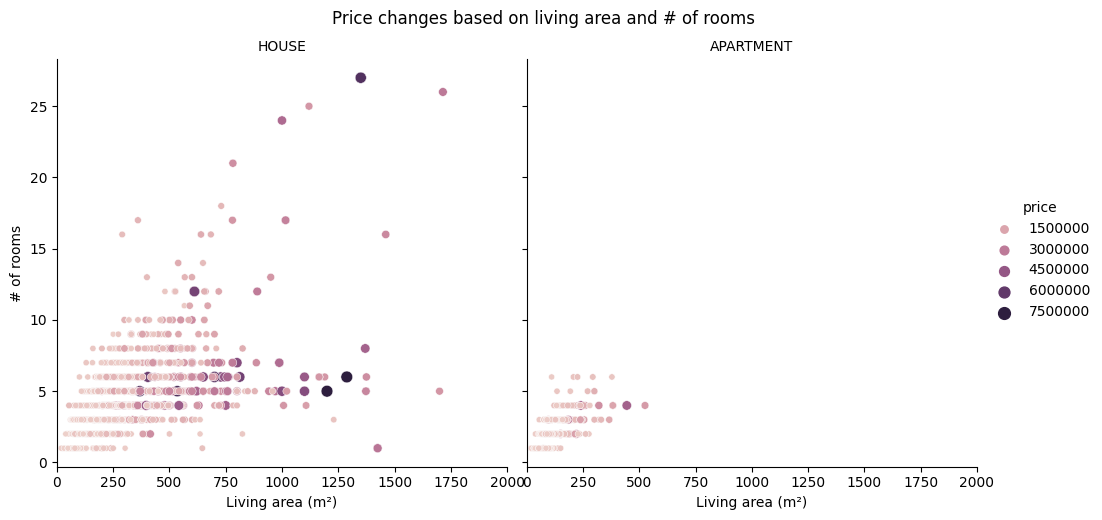

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

plot = sns.relplot(x = 'living_area', 
            y = 'number_rooms',
            data = csv,
            kind = 'scatter',
            col = 'property_type',
            size = 'price',
            hue = 'price'
            )
plot.fig.suptitle("Price changes based on living area and # of rooms", y=1.03)
plot.set_titles("{col_name}")
plot.set(xlabel="Living area (m²)", ylabel="# of rooms")
plt.xlim(0,2000)
plt.show()

We can see that while some of the more expensive houses have more rooms, living area seems to affect the price more. 

In the case of apartments we can see the same trend, except for one outlier. 

c:\Users\PC1\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


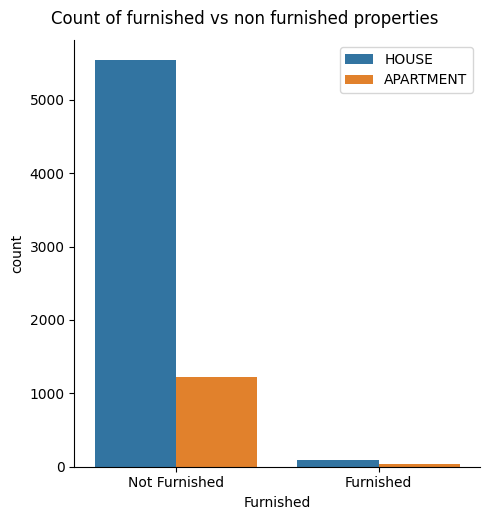

In [52]:
plot = sns.catplot(x = 'furnished', 
            data = csv,
            kind = 'count',
            hue = 'property_type',
            legend=None
            )
plot.set(xticklabels=["Not Furnished", "Furnished"])
plot.fig.suptitle("Count of furnished vs non furnished properties", y=1.03)
plot.set(xlabel="Furnished")
plt.legend(loc='upper right')
plt.show()

c:\Users\PC1\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


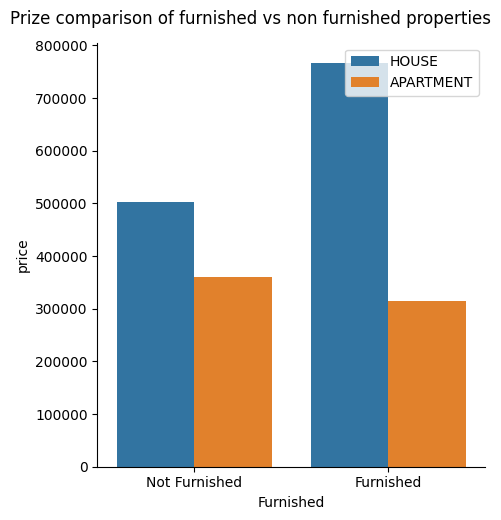

In [53]:
plot = sns.catplot(x = 'furnished', 
            y = 'price',
            data = csv,
            kind = 'bar',
            hue = 'property_type',
            errorbar = None, 
            legend=None
            )

plot.set(xticklabels=["Not Furnished", "Furnished"])
plot.fig.suptitle("Prize comparison of furnished vs non furnished properties", y=1.03)
plot.set(xlabel="Furnished")
plt.legend(loc='upper right')
plt.show()

Only a negligable amount of properties being sold are furnished. 

Interesting to see is that for apartments, the average sale price is higher when the apartment is furnished, while the reverse is true for houses. 

We have to consider that the price difference can be related to different things however. 

c:\Users\PC1\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\PC1\AppData\Local\Temp\ipykernel_17980\1827954512.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=1.0)


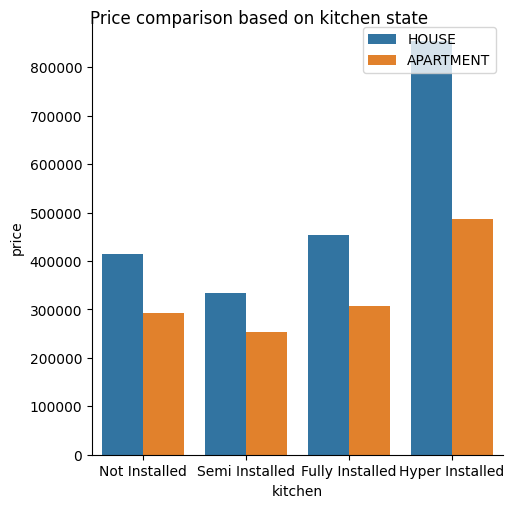

In [54]:
kitchen = sns.catplot(x = 'kitchen', 
                    y = 'price',
                    data = csv,
                    kind = 'bar',
                    hue = 'property_type',
                    errorbar = None,
                    legend=None
                    )
kitchen.set(xticklabels=["Not Installed", "Semi Installed", "Fully Installed", "Hyper Installed"])
kitchen.fig.suptitle("Price comparison based on kitchen state")
plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=1.0)
plt.legend(loc='upper right')
plt.show()

We can see that unless you have a hyper equipped kitchen, it does not affect the price very much.

c:\Users\PC1\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\PC1\AppData\Local\Temp\ipykernel_17980\3886168564.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


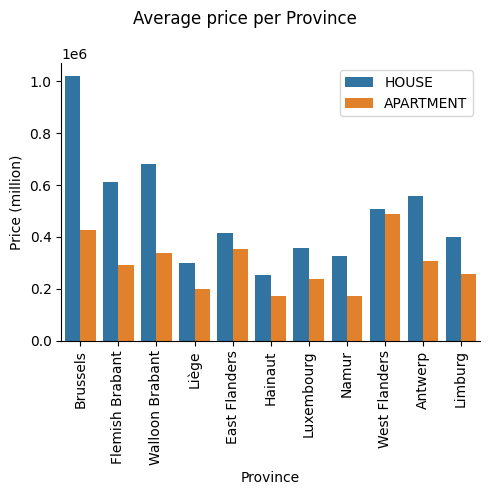

In [55]:
plot = sns.catplot(x = 'province', 
            y = 'price',
            data = csv,
            kind = 'bar',
            hue = 'property_type',
            errorbar = None,
            legend=None
            )
plot.fig.suptitle("Average price per Province")
plot.set(xlabel="Province", ylabel="Price (million)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()

c:\Users\PC1\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\PC1\AppData\Local\Temp\ipykernel_17980\1481981778.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


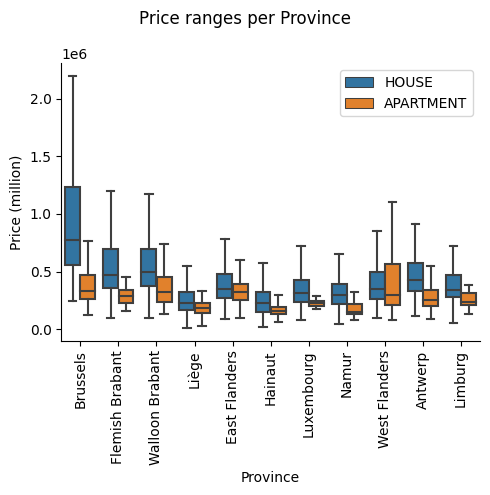

In [80]:
plot = sns.catplot(x = 'province', 
            y = 'price',
            data = csv,
            kind = 'box',
            hue = 'property_type',
            errorbar = None,
            legend=None, 
            sym = ""
            )
plot.fig.suptitle("Price ranges per Province")
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend(loc='upper right')
plot.set(xlabel="Province", ylabel="Price (million)")
plt.show()

There is a lot of variation in the price, there are quite a number of properties that are a lot more expensive then the mean price. 

The only exception for this are apartments in Luxembourg, they have a pretty set price range it seems (Though this is probably due to the fact our data set only has 13 apartments in Luxembourg).

c:\Users\PC1\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\PC1\AppData\Local\Temp\ipykernel_17980\2612471644.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


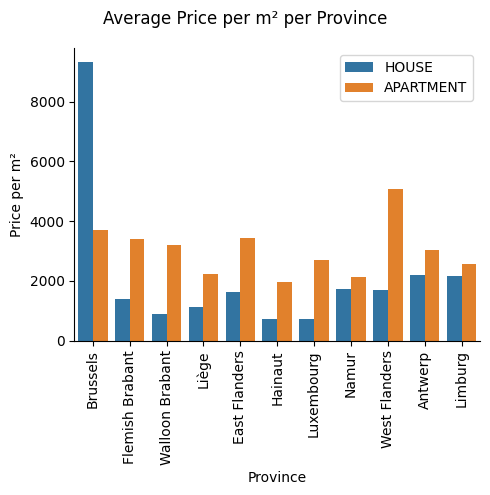

In [78]:
plot = sns.catplot(x = 'province', 
            y = 'ppm',
            data = csv,
            kind = 'bar',
            hue = 'property_type',
            errorbar = None,
            legend=None
            )
plot.fig.suptitle("Average Price per m² per Province")
plot.set(xlabel="Province", ylabel="Price per m²")
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()

In [95]:
csv[csv['province']=='Brussels']

,url,region,province,locality,property_type,property_subtype,price,number_rooms,living_area,kitchen,...,fireplace,terrace,terrace_area,garden,garden_area,surface_land,number_facades,swimming_pool,building_state,ppm
0,https://www.immoweb.be/en/classified/house/for...,Brussels,Brussels,Bruxelles,HOUSE,HOUSE,499000.0,4.0,155.0,2.0,...,0.0,1,28.0,1,75.0,210.0,2.0,0,GOOD,2376.190476
4,https://www.immoweb.be/en/classified/house/for...,Brussels,Brussels,Watermael-Boitsfort,HOUSE,HOUSE,499500.0,3.0,138.0,1.0,...,0.0,1,20.0,1,50.0,100.0,2.0,0,GOOD,4995.000000
17,https://www.immoweb.be/en/classified/house/for...,Brussels,Brussels,Laeken,HOUSE,HOUSE,525000.0,4.0,167.0,1.0,...,0.0,1,5.0,1,70.0,178.0,2.0,0,GOOD,2949.438202
18,https://www.immoweb.be/en/classified/apartment...,Brussels,Brussels,Anderlecht,HOUSE,APARTMENT_BLOCK,525000.0,3.0,240.0,1.0,...,0.0,1,26.0,1,28.0,131.0,2.0,0,GOOD,4007.633588
21,https://www.immoweb.be/en/classified/apartment...,Brussels,Brussels,Saint-Josse-ten-Noode,HOUSE,APARTMENT_BLOCK,530000.0,3.0,250.0,0.0,...,0.0,0,0.0,0,0.0,110.0,2.0,0,TO_BE_DONE_UP,4818.181818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19840,https://www.immoweb.be/en/classified/mixed-use...,Brussels,Brussels,Laeken,HOUSE,MIXED_USE_BUILDING,370000.0,4.0,175.0,0.0,...,0.0,0,0.0,0,0.0,65.0,2.0,0,GOOD,5692.307692
19876,https://www.immoweb.be/en/classified/house/for...,Brussels,Brussels,Uccle,HOUSE,HOUSE,1250000.0,5.0,300.0,2.0,...,1.0,1,25.0,1,62.0,168.0,2.0,0,JUST_RENOVATED,7440.476190
19884,https://www.immoweb.be/en/classified/house/for...,Brussels,Brussels,Evere,HOUSE,HOUSE,325000.0,4.0,133.0,0.0,...,0.0,0,0.0,1,25.0,75.0,2.0,0,TO_RENOVATE,4333.333333
19889,https://www.immoweb.be/en/classified/mansion/f...,Brussels,Brussels,Auderghem,HOUSE,MANSION,625000.0,5.0,183.0,1.0,...,0.0,0,0.0,1,67.0,130.0,2.0,0,TO_RENOVATE,4807.692308


- Represent the number of properties according to their surface using a histogram.

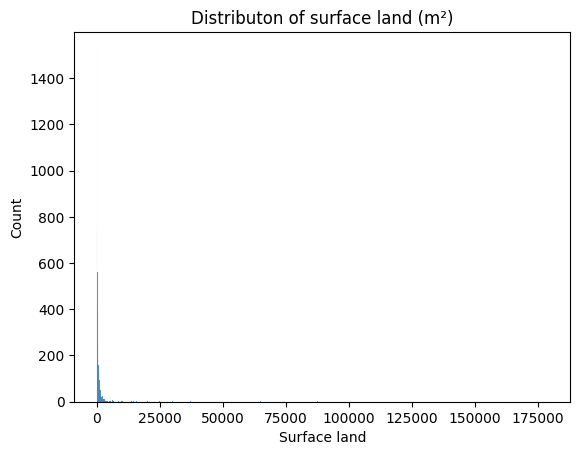

In [104]:
plot = sns.histplot(x = 'surface_land', 
            data = csv
            )
plot.set_title("Distributon of surface land (m²)")
plot.set(xlabel="Surface land")
plt.show()

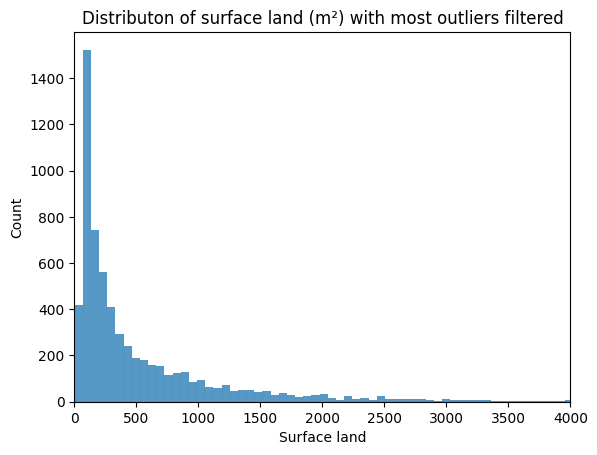

In [105]:
plot = sns.histplot(x = 'surface_land', 
            data = csv
            )
plt.xlim(0,4000)
plot.set_title("Distributon of surface land (m²) with most outliers filtered")
plot.set(xlabel="Surface land")
plt.show()

- In your opinion, which 5 variables are the most important and why?

Location

m² 

- What are the **most** expensive municipalities in Belgium? (Average price, median price, price per square meter)

In [115]:
mean = csv.groupby('locality')['price'].mean().sort_values(ascending=False).head(10)
median = csv.groupby('locality')['price'].median().sort_values(ascending=False).head(10)
ppm = csv.groupby('locality')['ppm'].mean().sort_values(ascending=False).head(10)

print(f"Average prices of the most expensive municipalities in Belgium:")
print(mean)

print(f"Median prices of the most expensive municipalities in Belgium:")
print(median)

print(f"Average price per m² of the most expensive municipalities in Belgium:")
print(ppm)

Average prices of the most expensive municipalities:
locality
Raeren                 5400000.0
Knokke-Heist Knokke    5095000.0
Mont-Saint-Guibert     3790000.0
St-Genesius-Rode       2590000.0
Knokke-Zoute           2423000.0
Braine l'Alleud        2350000.0
ZOMERGEM               2250000.0
marbella               2150000.0
Grez-Doiceau           2128300.0
SINT-MARTENS-LATEM     1900000.0
Name: price, dtype: float64
Median prices of the most expensive municipalities:
locality
Raeren                 5400000.0
Knokke-Heist Knokke    5095000.0
Mont-Saint-Guibert     3790000.0
St-Genesius-Rode       2590000.0
Braine l'Alleud        2350000.0
ZOMERGEM               2250000.0
marbella               2150000.0
SINT-MARTENS-LATEM     1900000.0
Bruxelles ville        1850000.0
PLANCENOIT             1785000.0
Name: price, dtype: float64
Average price per m² of the most expensive municipalities:
locality
Dinant Anseremme         285000.000000
Houthalen-Helchteren      56788.320209
Hoegaarden Outg

In [120]:
mean = csv[csv['region'] == 'Wallonie'].groupby('locality')['price'].mean().sort_values(ascending=False).head(10)
median = csv[csv['region'] == 'Wallonie'].groupby('locality')['price'].median().sort_values(ascending=False).head(10)
ppm = csv[csv['region'] == 'Wallonie'].groupby('locality')['ppm'].mean().sort_values(ascending=False).head(10)

print(f"Average prices of the most expensive municipalities in Wallonie:")
print(mean)

print(f"Median prices of the most expensive municipalities in Wallonie:")
print(median)

print(f"Average price per m² of the most expensive municipalities in Wallonie:")
print(ppm)

Average prices of the most expensive municipalities in Wallonie:
locality
Raeren                5400000.0
Mont-Saint-Guibert    3790000.0
Braine l'Alleud       2350000.0
Grez-Doiceau          2128300.0
PLANCENOIT            1785000.0
Pommeroeul            1750000.0
Braine-le-Château     1650000.0
VAUX-ET-BORSET        1650000.0
Saint-Vith            1500000.0
Clavier               1499000.0
Name: price, dtype: float64
Median prices of the most expensive municipalities in Wallonie:
locality
Raeren                5400000.0
Mont-Saint-Guibert    3790000.0
Braine l'Alleud       2350000.0
PLANCENOIT            1785000.0
Pommeroeul            1750000.0
Braine-le-Château     1650000.0
VAUX-ET-BORSET        1650000.0
Saint-Vith            1500000.0
Clavier               1499000.0
Corroy le Grand       1495000.0
Name: price, dtype: float64
Average price per m² of the most expensive municipalities in Wallonie:
locality
Dinant Anseremme      285000.000000
ENGHIEN                14750.000000
Mont-

In [121]:
mean = csv[csv['region'] == 'Flanders'].groupby('locality')['price'].mean().sort_values(ascending=False).head(10)
median = csv[csv['region'] == 'Flanders'].groupby('locality')['price'].median().sort_values(ascending=False).head(10)
ppm = csv[csv['region'] == 'Flanders'].groupby('locality')['ppm'].mean().sort_values(ascending=False).head(10)

print(f"Average prices of the most expensive municipalities in Flanders:")
print(mean)

print(f"Median prices of the most expensive municipalities in Flanders:")
print(median)

print(f"Average price per m² of the most expensive municipalities in Flanders:")
print(ppm)

Average prices of the most expensive municipalities in Flanders:
locality
Knokke-Heist Knokke    5.095000e+06
St-Genesius-Rode       2.590000e+06
Knokke-Zoute           2.423000e+06
ZOMERGEM               2.250000e+06
SINT-MARTENS-LATEM     1.900000e+06
Rhode-Saint-Genèse     1.774167e+06
Maarkedal              1.750000e+06
RHODE-SAINT-GENÈSE     1.717500e+06
Rhode-Saint-Genese     1.650500e+06
Poppel                 1.600000e+06
Name: price, dtype: float64
Median prices of the most expensive municipalities in Flanders:
locality
Knokke-Heist Knokke    5095000.0
St-Genesius-Rode       2590000.0
ZOMERGEM               2250000.0
SINT-MARTENS-LATEM     1900000.0
Maarkedal              1750000.0
RHODE-SAINT-GENÈSE     1717500.0
Poppel                 1600000.0
SINT-GENESIUS-RODE     1495000.0
Zwijnaarde             1495000.0
Rhode-St-Genèse        1447500.0
Name: price, dtype: float64
Average price per m² of the most expensive municipalities in Flanders:
locality
Houthalen-Helchteren     56

In [ ]:
mean = csv.groupby('locality')['price'].mean().sort_values(ascending=True).head(10)
median = csv.groupby('locality')['price'].median().sort_values(ascending=True).head(10)
ppm = csv.groupby('locality')['ppm'].mean().sort_values(ascending=True).head(10)

print(f"Average prices of the least expensive municipalities in Belgium:")
print(mean)

print(f"Median prices of the least expensive municipalities in Belgium:")
print(median)

print(f"Average price per m² of the least expensive municipalities in Belgium:")
print(ppm)

In [122]:
mean = csv[csv['region'] == 'Wallonie'].groupby('locality')['price'].mean().sort_values(ascending=True).head(10)
median = csv[csv['region'] == 'Wallonie'].groupby('locality')['price'].median().sort_values(ascending=True).head(10)
ppm = csv[csv['region'] == 'Wallonie'].groupby('locality')['ppm'].mean().sort_values(ascending=True).head(10)

print(f"Average prices of the least expensive municipalities in Wallonie:")
print(mean)

print(f"Median prices of the least expensive municipalities in Wallonie:")
print(median)

print(f"Average price per m² of the least expensive municipalities in Wallonie:")
print(ppm)

Average prices of the least expensive municipalities in Wallonie:
locality
Doische Gimnée                      39900.0
Aiseau-Presles                      40000.0
Angre                               49000.0
Auvelais (Sambreville)              78500.0
Florenville Villers-devant-Orval    79000.0
Wanfercée-Baulet                    85000.0
Wasmes                              85000.0
PÃturages                           86000.0
LAMORTEAU                           88000.0
Quievrain                           90000.0
Name: price, dtype: float64
Median prices of the least expensive municipalities in Wallonie:
locality
Doische Gimnée                      39900.0
Aiseau-Presles                      40000.0
PÃturages                           49000.0
Angre                               49000.0
Auvelais (Sambreville)              78500.0
Florenville Villers-devant-Orval    79000.0
Wanfercée-Baulet                    85000.0
Wasmes                              85000.0
LAMORTEAU                      

In [ ]:
mean = csv[csv['region'] == 'Flanders'].groupby('locality')['price'].mean().sort_values(ascending=True).head(10)
median = csv[csv['region'] == 'Flanders'].groupby('locality')['price'].median().sort_values(ascending=True).head(10)
ppm = csv[csv['region'] == 'Flanders'].groupby('locality')['ppm'].mean().sort_values(ascending=True).head(10)

print(f"Average prices of the least expensive municipalities in Flanders:")
print(mean)

print(f"Median prices of the least expensive municipalities in Flanders:")
print(median)

print(f"Average price per m² of the least expensive municipalities in Flanders:")
print(ppm)

In [133]:
heatmap = csv[['price', 'number_rooms', 'living_area', 'kitchen', 'furnished', 'fireplace', 'terrace', 'terrace_area', 'garden', 'garden_area', 'surface_land', 'number_facades', 'swimming_pool']]
#del heatmap['url']
#del heatmap['region']
#del heatmap['locality']


heatmap.head()

,price,number_rooms,living_area,kitchen,furnished,fireplace,terrace,terrace_area,garden,garden_area,surface_land,number_facades,swimming_pool
0,499000.0,4.0,155.0,2.0,0,0.0,1,28.0,1,75.0,210.0,2.0,0
1,499000.0,3.0,135.0,1.0,0,0.0,1,15.0,1,275.0,559.0,3.0,0
4,499500.0,3.0,138.0,1.0,0,0.0,1,20.0,1,50.0,100.0,2.0,0
5,500000.0,5.0,265.0,0.5,0,0.0,1,76.0,1,457.0,857.0,4.0,0
6,510000.0,3.0,168.0,2.0,0,1.0,1,24.0,1,550.0,702.0,4.0,0


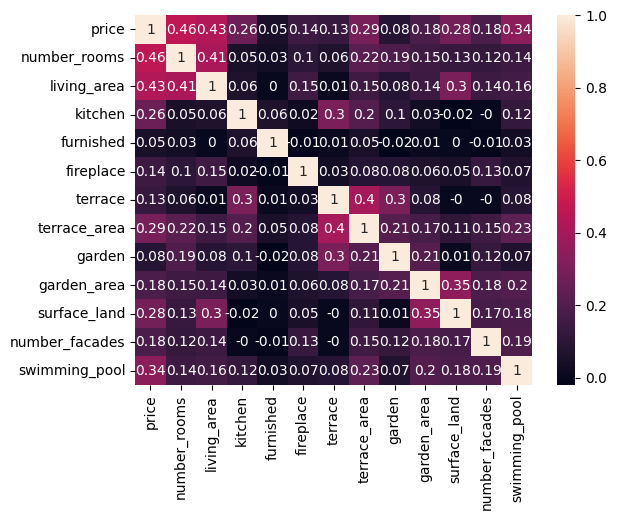

In [134]:
matrix = heatmap.corr(
    method = 'pearson',  # The method of correlation
    min_periods = 1      # Min number of observations required
).round(2)

sns.heatmap(matrix, annot=True)
plt.show()